In [1]:
# Activate your environment
import Pkg
Pkg.activate("../KellyEnv")

  Activating project at `c:\Users\Zahnbuerste_HQ\Documents\AA_Studium\Master\05_Masterarbeit\Playground\VS_refactor\KellyEnv`


In [2]:
using UnfoldSim
using Unfold
using StableRNGs
using SequentialSamplingModels
using CairoMakie, UnfoldMakie

In [3]:
include(joinpath(pathof(Unfold),"..","eventhandling.jl"))

copy_eventinfo!

In [4]:
using Statistics
function add_rt_to_events_and_slow_flag(evts, evt_char)
    original_onsets = diff(evts.latency; dims=1)
    original_onsets = vcat(original_onsets, 600)
    evts.rt = original_onsets
    # Add slow_response flag
    mask = evts.event .== evt_char
    # Calculate the median only for the rows where the mask is true
    filtered_rt = evts.rt[mask]  
    med_rt = median(filtered_rt)
    # Initialize slow_response column with false
    evts.slow_response = falses(size(evts.rt))
    # Apply the condition only to the masked rows
    evts.slow_response[mask] .= filtered_rt .> med_rt
    return evts
end

add_rt_to_events_and_slow_flag (generic function with 1 method)

# Setup

In [5]:
rng = StableRNG(12)
dm = 1.2 #1.2; # mean drift rate /sec
ds = .5; #0.5 std of drift rate /sec
bcr = 0.8; # assume a collapsing bound at this rate /sec, let's say bound starts at 1 and collapses toward zero at 2 sec. Almost ruling out misses.
# Let's generate a bunch of drift rates and record them:
d = dm .+ ds .* randn(rng, 300,1)
drift_rates_500 = [ [abs(x[1])] for x in eachrow(d)]

300-element Vector{Vector{Float64}}:
 [1.3917691324233592]
 [2.003535675368618]
 [1.9851867068840674]
 [1.3087447175435842]
 [1.1166102127805602]
 [0.3292688156777278]
 [0.9410847761309205]
 [0.32297032594067887]
 [2.1367071117042347]
 [0.7237463740211811]
 ⋮
 [1.2679883239119776]
 [0.839467893195152]
 [1.472297989055857]
 [1.6294440929799676]
 [1.0196992893664152]
 [1.1939912954256893]
 [1.0474942402278222]
 [0.2894924447270395]
 [0.7071991512350786]

In [6]:
fs = 200
Δt = 1/fs; # time step
tEnd = 2 # trial Duration
time_vec = 0:Δt:tEnd; # time base - let's make it a typical stimulus duration
max_length = tEnd/Δt

design_single = SingleSubjectDesign(conditions = Dict(:drift_rate => drift_rates_500, :condition => [1]))
design_seq = SequenceDesign(design_single,"SR")
design_rep = RepeatDesign(design_seq,1)

RepeatDesign{SequenceDesign{SingleSubjectDesign}}
  design: SequenceDesign{SingleSubjectDesign}
  repeat: Int64 1


# Components

In [7]:
resp = LinearModelComponent(;
    basis = UnfoldSim.hanning(Int(tEnd * fs)),
    formula = @formula(0 ~ 1 + condition),
    β = [0, 0],
)

lba_parameter = Dict(:ν=>"drift_rate", :A=>0.01, :k=>0.8, :τ=>0.0, :σ=>0)

drift = DriftComponent(max_length,fs,LBA,lba_parameter)
components = Dict('S' => [drift], 'R' => [resp])

Dict{Char, Vector} with 2 entries:
  'R' => LinearModelComponent[LinearModelComponent([0.0, 6.19933e-5, 0.00024795…
  'S' => DriftComponent[DriftComponent(400, 200, LBA, Dict{Symbol, Any}(:ν=>"dr…

# Onset

In [8]:
seq_onset = SequenceOnset(
    Dict('S'=>DriftOnset(),
         #'C'=>DriftOnset(),
         'R'=>UniformOnset(width=0,offset=(tEnd*fs))))

SequenceOnset(Dict{Char, AbstractOnset}('R' => UniformOnset
  width: Int64 0
  offset: Int64 400
, 'S' => DriftOnset{UniformOnset}(UniformOnset
  width: Int64 0
  offset: Int64 0
)))

# Simulation

In [9]:
data, evts = UnfoldSim.simulate(
    rng,
    design_rep,
    components,
    seq_onset,
    NoNoise() 
)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 600×4 DataFrame
 Row │ drift_rate  condition  event  latency 
     │ Array…      Int64      Char   Any     
─────┼───────────────────────────────────────
   1 │ [1.39177]           1  S      401
   2 │ [1.39177]           1  R      517
   3 │ [2.00354]           1  S      917
   4 │ [2.00354]           1  R      997
   5 │ [1.98519]           1  S      1397
   6 │ [1.98519]           1  R      1478
   7 │ [1.30874]           1  S      1878
   8 │ [1.30874]           1  R      2001
  ⋮  │     ⋮           ⋮        ⋮       ⋮
 594 │ [1.19399]           1  R      169513
 595 │ [1.04749]           1  S      169913
 596 │ [1.04749]           1  R      170066
 597 │ [0.289492]          1  S      170466
 598 │ [0.289492]          1  R      170866
 599 │ [0.707199]          1  S      171266
 600 │ [0.707199]          1  R      171495
                             585 rows omitted)

In [10]:
evts = add_rt_to_events_and_slow_flag(evts, 'S');

In [11]:
evts2  = deepcopy(evts)
evts2.trial_type = evts2.event
#copy_eventinfo!(evts2,'R'=>'S',"slow_response";match_fun="s after t")
copy_eventinfo!(evts2,'S'=>'R',"slow_response";match_fun="s before t");

# Plots

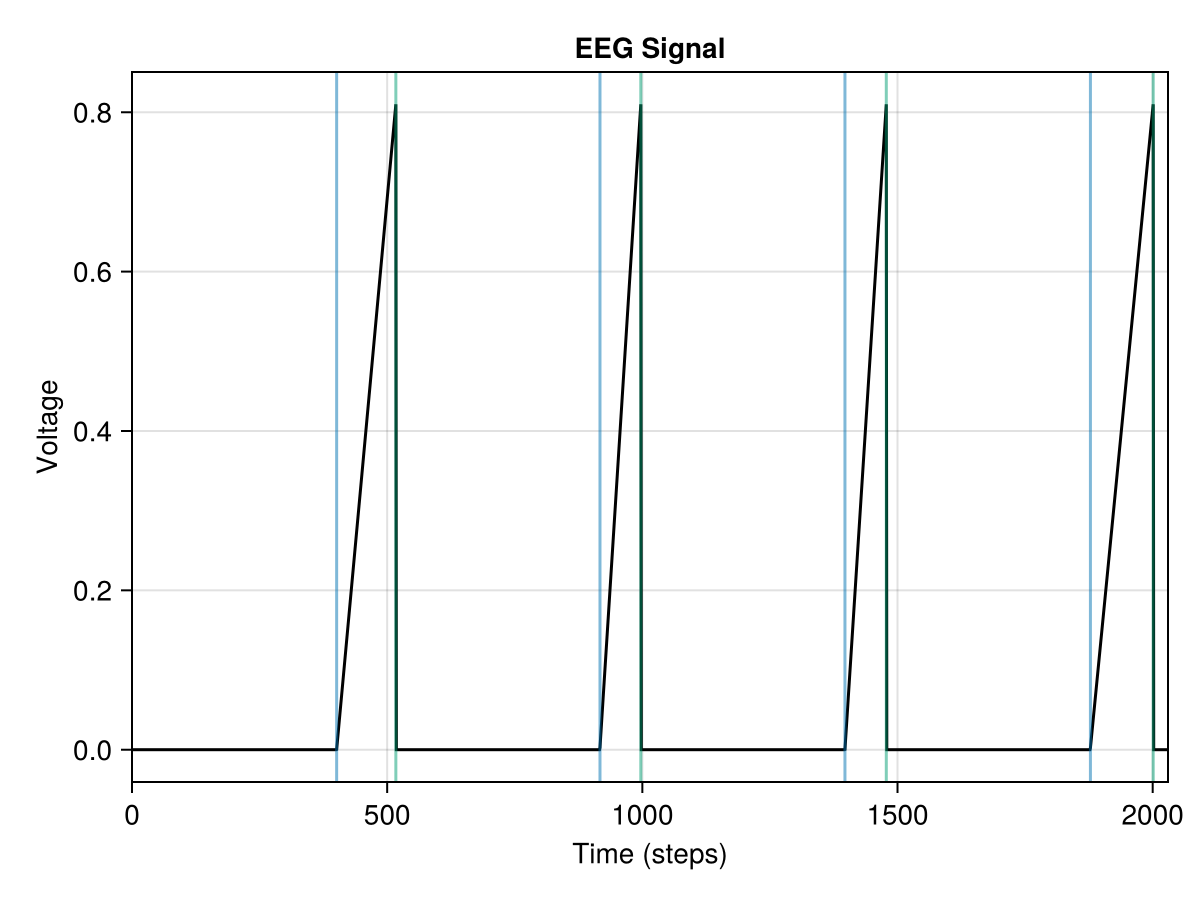

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time (steps)", ylabel="Voltage", title="EEG Signal")
lines!(data[1:2030], color=(:black, 1))
evts_limited = deepcopy(evts)[1:8, :]
CairoMakie.xlims!(0, 2030)
vlines!(evts_limited.latency[evts_limited.event.=='S'], color = (Makie.wong_colors()[1], 0.5))
#vlines!(evts_limited.latency[evts_limited.event.=='C'], color = (Makie.wong_colors()[2], 0.5))
vlines!(evts_limited.latency[evts_limited.event.=='R'], color = (Makie.wong_colors()[3], 0.5))
#current_figure()
# Display the plot
display(fig)

(isnothing(evts), isnothing(tbl)) = (false, false)


┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Missings in data - we remove any trial from data and designmatrix
└ @ Unfold C:\Users\Zahnbuerste_HQ\.julia\packages\Unfold\5pvbP\src\solver\prepare.jl:19


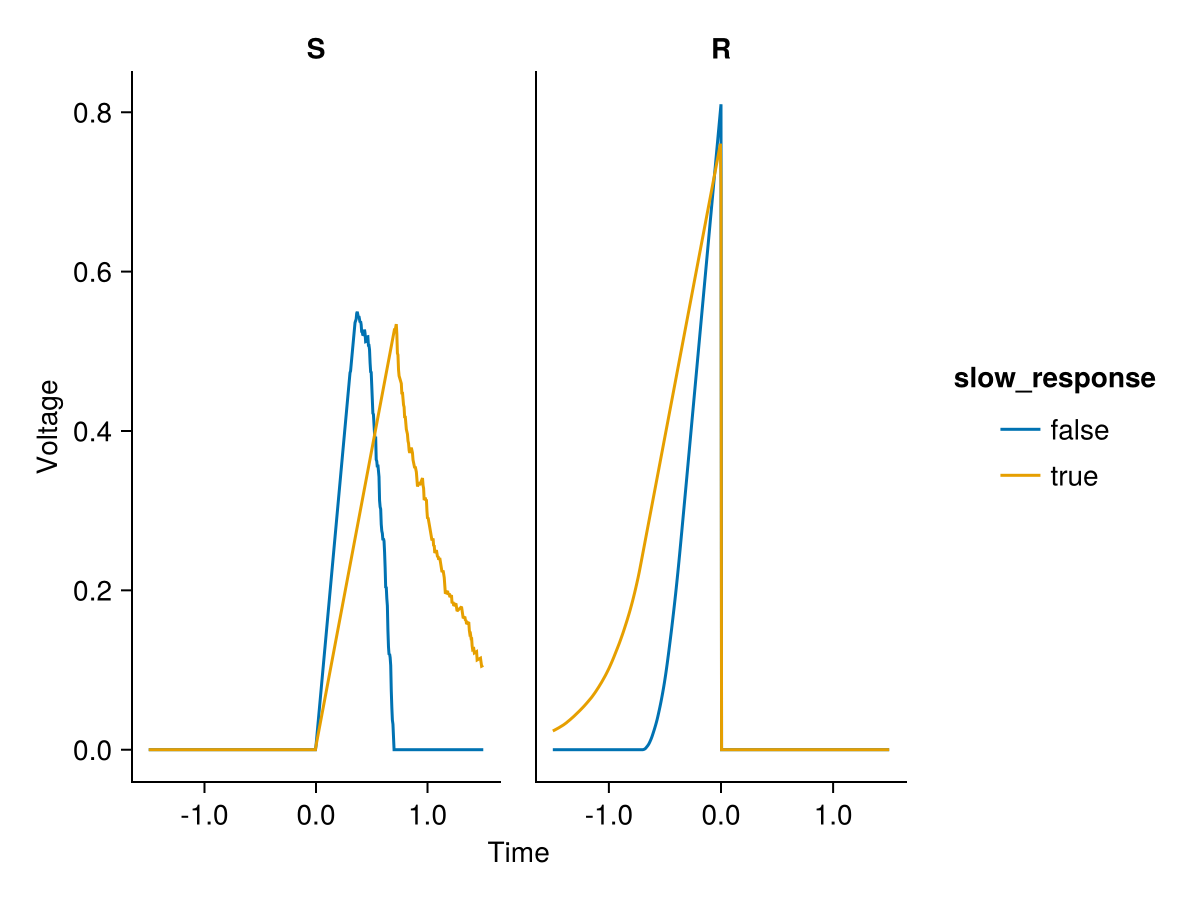

In [13]:
# ## Plot ERP of simulated EEG
evts2.event = string.(evts2.event)
data_epochs, times_epoch = Unfold.epoch(data = data, tbl = evts2, τ = (-1.5, 1.5), sfreq = fs);
f = @formula(0 ~ 1 + slow_response)
m = fit(UnfoldModel, ["S"=>(f,times_epoch),"R"=>(f,times_epoch)], evts2, data_epochs);
results_m = effects(Dict(:slow_response=>[true,false]),m)
results_m.slow_response = string.(results_m.slow_response)
plot_erp(results_m;mapping=(;color=:slow_response,col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter("S","R")))

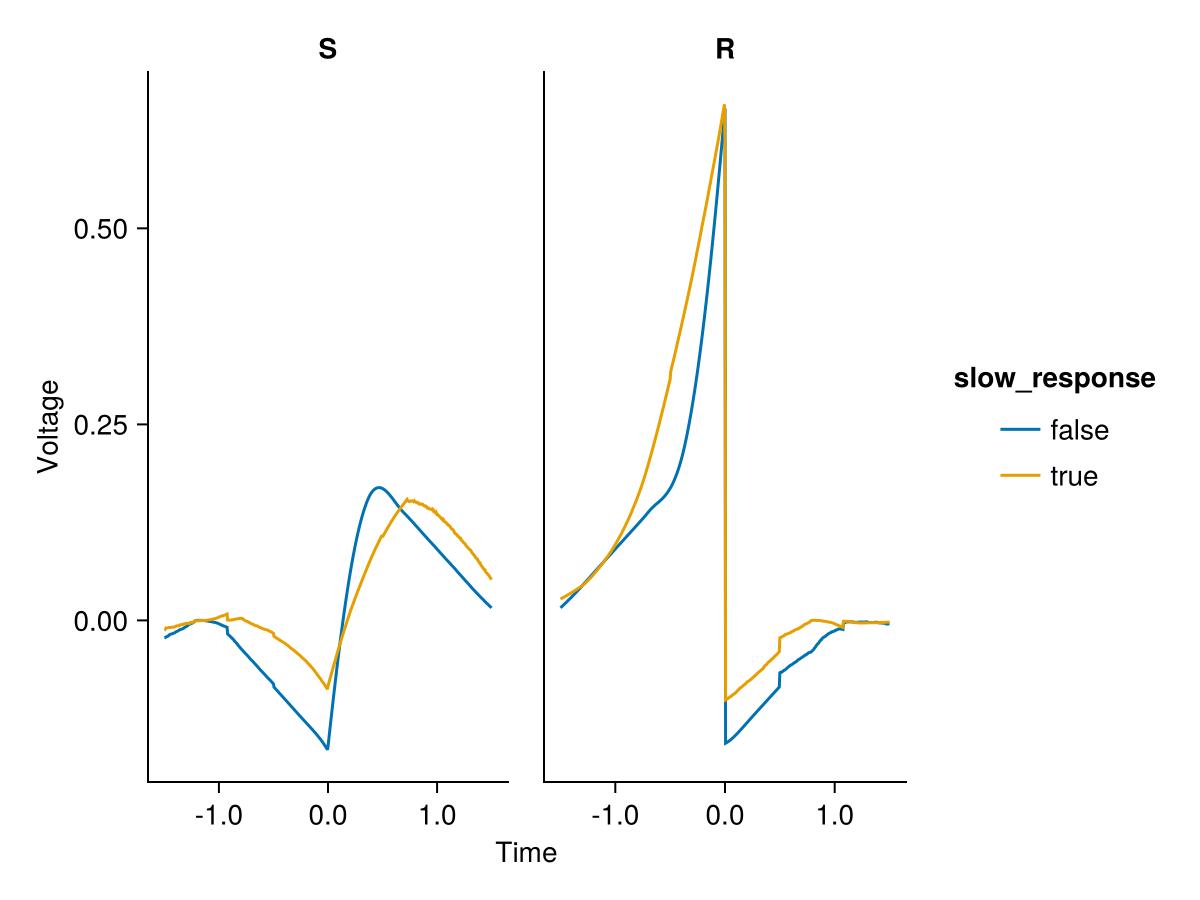

In [14]:
# ## Deconvolution of the overlap
fir_S = firbasis(τ=(-1.5,1.5),sfreq=fs)
fir_R = firbasis(τ=(-1.5,1.5),sfreq=fs)

evts3 = deepcopy(evts2)
evts3.event = string.(evts3.event)
m = fit(UnfoldModel, ["S"=>(f,fir_S),"R"=>(f,fir_R)], evts3, data);
results_m_erp = effects(Dict(:slow_response=>[true,false]),m)
results_m_erp.slow_response = string.(results_m_erp.slow_response)

h = plot_erp(results_m_erp; 
    mapping=(; color=:slow_response, 
              col=:eventname => UnfoldMakie.AlgebraOfGraphics.sorter(["S", "R"])))

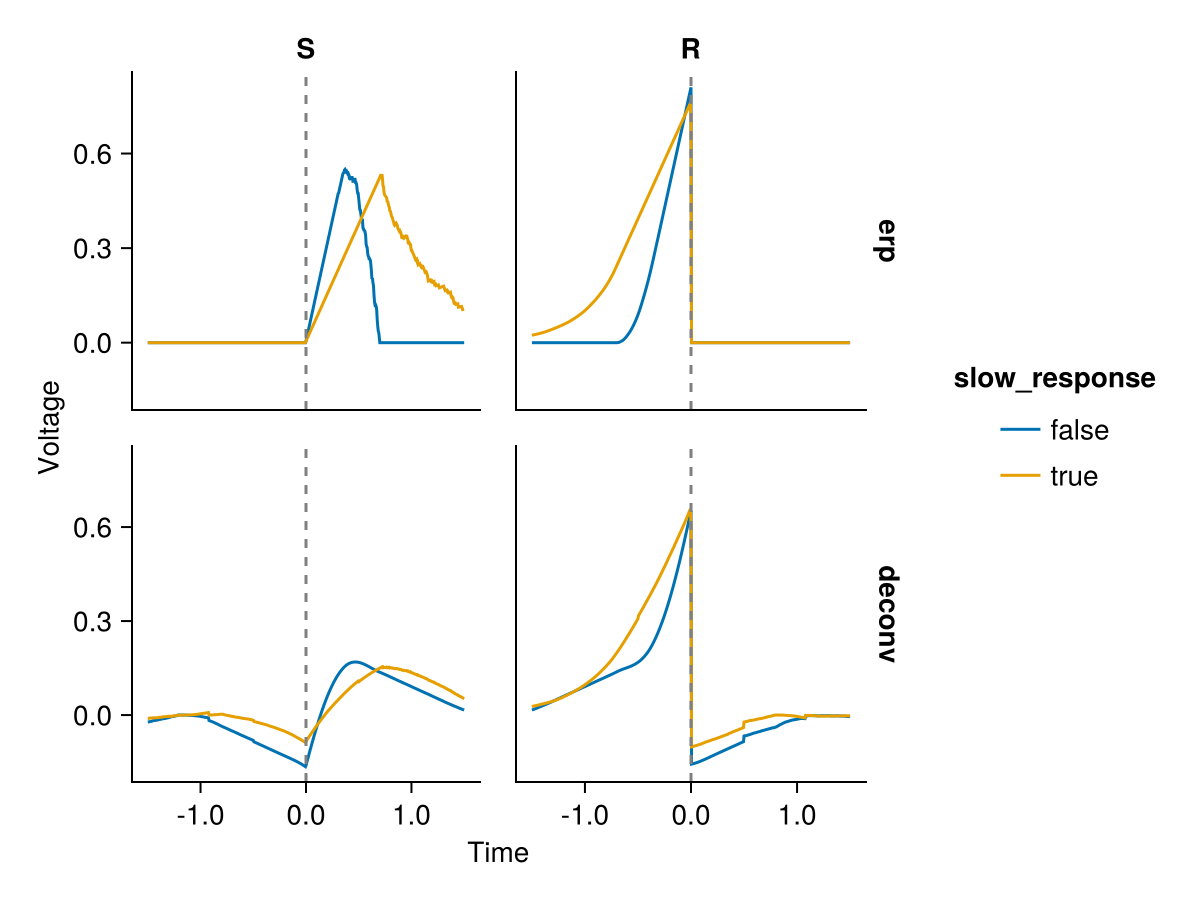

In [15]:
results_m.group .= "erp"
results_m_erp.group .= "deconv"
c = vcat(results_m,results_m_erp)
h = plot_erp(c;mapping=(;color=:slow_response,col=:eventname=>UnfoldMakie.AlgebraOfGraphics.sorter(["S","R"]),
            row=:group=>UnfoldMakie.AlgebraOfGraphics.sorter(["erp","deconv"])))
vlines!.(h.content[1:4],[0],linestyle=:dash,color=:gray)
current_figure()